In [6]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm
from distance import levenshtein
import os
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils import data
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import import_ipynb

data_file = 'TTScorpora.tsv'

In [7]:
class Config:
    seed = '5'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dict_name = 'rcrl_apd.1.4.1.txt'
    epochs = 200
    batch_size = 128
    hidden_dim = 128
    embed_dim = 128
    dropout = 0.5
    dec_max_len = 30
    MAX_LENGTH = 20
    teacher_forcing_ratio = 0.1
    n_layers = 2
    lr = 0.001


cfg = Config()

In [8]:
def dict_sorting (dict_file_name):
    dict_file = open(dict_file_name, 'r')
    lines_dict = dict_file.readlines()
    dict_file.close()

    graphemes = []
    phonemes = []

    for i in range(0, len(lines_dict)):
        lines_dict[i] = lines_dict[i].split()
        graphemes.append([*lines_dict[i][0]])
        phonemes.append(lines_dict[i][1:])
    phonemes = [a for b in phonemes for a in b]
    graphemes = [a for b in graphemes for a in b]
    graphemes = sorted(set(graphemes))
    phonemes = sorted(set(phonemes))
    return graphemes, phonemes

dict_file_name = cfg.dict_name
g_seq, p_seq = dict_sorting(dict_file_name)
cfg.graphemes = ["<pad>", "<unk>", "</s>"] + g_seq
cfg.phonemes = ["<pad>", "<unk>", "<s>", "</s>"] + p_seq

#Index to grapheme and phones for vectors
cfg.graph2index = {g: idx for idx, g in enumerate(cfg.graphemes)}
cfg.index2graph = {idx: g for idx, g in enumerate(cfg.graphemes)}

cfg.phone2index = {p: idx for idx, p in enumerate(cfg.phonemes)}
cfg.index2phone = {idx: p for idx, p in enumerate(cfg.phonemes)}

# print(cfg.graphemes)
# print(cfg.phonemes)
cfg.g_vocab_size = len(cfg.graphemes)
cfg.p_vocab_size = len(cfg.phonemes)
# print(cfg.g_vocab_size, cfg.p_vocab_size)
# print(cfg.phone2index)
# print(cfg.index2phone)

In [9]:
def split_nums_letters(seq):
    nums = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','30','40','50','60','70','80','90','100']
    num_words = ['nul', 'een','twee', 'drie','vier','vyf', 'ses','sewe', 'agt', 'nege','tien','elf','twaalf','dertien','veertien','vyftien','sestien','sewentien', 'agtien', 'negentien', 
        'twintig','dertig', 'veertig', 'vyftig', 'sestig', 'sewentig', 'tagtig', 'negentig', 'honderd']
    
    num_tens = ['10', '20','30','40','50','60','70','80','90']
    num_words_tens = ['tien', 'twintig','dertig', 'veertig', 'vyftig', 'sestig', 'sewentig', 'tagtig', 'negentig']
    nums_dict_combined = dict(zip(nums,num_words))
    nums_tens_dict = dict(zip(num_tens, num_words_tens))

    def num_to_word(h,t,u, flag, max_len, curr_str_len):
        ans = ""
        h_added = 0
        t_u_combined = 0
        req_suffix = 0
        end = ['biljoen', 'miljoen', 'duisend']
        #print(f"h{h}, t{t}, u{u}")
        if h:
            if h!="0":
                ans = ans + nums_dict_combined[h] + " honderd"
                h_added = 1
                req_suffix = 1
        if h=='0' and (t!="0" or u!="0") and curr_str_len: 
            ans = ans + "en "

        if (t+u):
            if (t+u)!="00" and nums_dict_combined.get(t+u):
                    if h_added: ans = ans +" en "+ nums_dict_combined[t+u]
                    else: ans = ans + nums_dict_combined[t+u]
                    t_u_combined = 1
                    req_suffix = 1

        if t_u_combined == 0:
            if t!="0" and u!="0" and t_u_combined == 0:
                    if h_added: ans = ans +" "+ nums_dict_combined[u] + " en " +  num_words_tens[int(t)-1]
                    else: ans = ans + nums_dict_combined[u] + " en " +  num_words_tens[int(t)-1]
                    req_suffix = 1

            elif t!="0" and t_u_combined == 0:
                    if h_added: ans = ans +" en "+ nums_tens_dict[int(t)]
                    else: ans = ans + nums_dict_combined[t]
                    req_suffix = 1

            elif u!="0" and t_u_combined == 0:
                if h_added: ans = ans +" en "+ nums_dict_combined[u]
                else: ans = ans + nums_dict_combined[u]
                req_suffix = 1

        if flag!=(max_len-1) and req_suffix and len(ans): ans = ans +" " + end[flag]

        return ans



    def convert_num_seq(num):

        a = int(num)
        max_len = 4


        num_word_equiv = ""
        tu_both = 0
        t_added = 0
        h_added = 0
        tt_th_both = 0
        tt_added = 0
        ht_added = 0

        bu = str(int(a/1000000000)-10*int(a/10000000000))
        bt = str(int(a/10000000000)-10*int(a/100000000000))
        bh = str(int(a/100000000000))
        
        mu = str(int(a/1000000)-10*int(a/10000000))
        mt = str(int(a/10000000)-10*int(a/100000000))
        mh = str(int((a%1000000000)/100000000))

        uth = str(int(a/1000)-10*int(a/10000))
        tth = str(int(a/10000)-10*int(a/100000))
        hth = str(int((a%1000000)/100000))

        u =  str(int(a%10))
        t =  str(int((a%100)/10))
        h =  str(int((a%1000)/100))
        #t_u = str(a%100)

        digits = [bh, bt, bu, mh, mt, mu, hth, tth, uth, h, t ,u]

        for i in range(max_len):
            flag = i #Use to add hondered or miljoen
            new_str = num_to_word(digits[i*3], digits[i*3+1], digits[(i*3)+2], flag, max_len, len(num_word_equiv))
            #if len(num_word_equiv) and len(new_str):num_word_equiv = num_word_equiv + " en " +  new_str
            if len(new_str):
                if len(num_word_equiv): num_word_equiv +=  (" " + new_str)
                else: num_word_equiv +=  (new_str)

            
        return num_word_equiv

    c = re.findall(r'[A-Za-z]+|\d+', seq) #Source: https://stackoverflow.com/questions/28290492/python-splitting-numbers-and-letters-into-sub-strings-with-regular-expression
    ans = []
    for j,i in enumerate(c):
        if i.isdigit():
            ans.append(convert_num_seq(i))
        else: ans.append(i)

    return ans
print(split_nums_letters("6000000000"))
print(split_nums_letters("11120"))
print(split_nums_letters("80000"))
print(split_nums_letters('99999'))
print(split_nums_letters('180125'))
print(split_nums_letters('180125000'))
print(split_nums_letters('109999989009'))


['ses biljoen']
['elf duisend een honderd en twintig']
['tagtig duisend']
['nege en negentig duisend nege honderd nege en negentig']
['een honderd en tagtig duisend een honderd vyf en twintig']
['een honderd en tagtig miljoen een honderd vyf en twintig duisend']
['een honderd en nege biljoen nege honderd nege en negentig miljoen nege honderd nege en tagtig duisend en nege']


In [10]:
a = [0,0,0]
if a: print(True)

True


In [11]:
# a = 5
# print(str(int(a%10)))
# print(int((a%100)/10))
# print(int((a%1000)/100))
# a = [1,0,0]
# if a: print(True)
nums = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','30','40','50','60','70','80','90','100']
num_words = ['nul', 'een','twee', 'drie','vier','vyf', 'ses','sewe', 'agt', 'nege','tien','elf','twaalf','dertien','veertien','vyftien','sestien','sewentien', 'agtien', 'negentien', 
    'twintig','dertig', 'veertig', 'vyftig', 'sestig', 'sewentig', 'tagtig', 'negentig', 'honderd']

num_tens = ['10', '20','30','40','50','60','70','80','90']
num_words_tens = ['tien', 'twintig','dertig', 'veertig', 'vyftig', 'sestig', 'sewentig', 'tagtig', 'negentig']
nums_dict_combined = dict(zip(nums,num_words))
nums_tens_dict = dict(zip(num_tens, num_words_tens))
print(nums_dict_combined['1'])

een


In [12]:
def preprocess_data(data_file_name, nonums_data_file_name):

    nums = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','30','40','50','60','70','80','90','100', '1000']
    num_words = ['nul', 'een','twee', 'drie','vier','vyf', 'ses','sewe', 'agt', 'nege','tien','elf','twaalf','dertien','veertien','vyftien','sestien','sewentien', 'agtien', 'negentien', 
            'twintig','dertig', 'veertig', 'vyftig', 'sestig', 'sewentig', 'tagtig', 'negentig', 'honderd', 'duisend']

    data_file = open(data_file_name, 'r')
    lines_data = data_file.readlines()
    data_file.close()


    #Converting to lowercase
    for i in range(0, len(lines_data)):
        lines_data[i] = lines_data[i].split()
        #l
        
        for j in range(0, len(lines_data[i])):
            lines_data[i][j] = lines_data[i][j].lower()

                 

    with open(nonums_data_file_name, 'w') as file:
        for i in range(0, len(lines_data)):
            new_line = " ".join([word for word in lines_data[i][1:]])
            file.write('%s \n' %new_line)
    file.close()

def see_all_unique_words(data_file_name, unique_words_file):

    nums = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','30','40','50','60','70','80','90','100']
    num_words = ['nul', 'een','twee', 'drie','vier','vyf', 'ses','sewe', 'agt', 'nege','tien','elf','twaalf','dertien','veertien','vyftien','sestien','sewentien', 'agtien', 'negentien', 
            'twintig','dertig', 'veertig', 'vyftig', 'sestig', 'sewentig', 'tagtig', 'negentig', 'een honderd']

    data_file = open(data_file_name, 'r')
    lines_data = data_file.readlines()
    data_file.close()


    #Converting to lowercase
    for i in range(0, len(lines_data)):
        #" ".join([word for word in lines_data[i])
        lines_data[i] = split_nums_letters(lines_data[i])
        line = " ".join(str(word) for word in lines_data[i])

        lines_data[i] = line.split()
        for j in range(0, len(lines_data[i])):
            lines_data[i][j] = lines_data[i][j].replace("-", " ")
            lines_data[i][j] = lines_data[i][j].replace("+", " ")
            lines_data[i][j] = lines_data[i][j].replace("%", "persent")
            lines_data[i][j] = lines_data[i][j].replace('\"', "")
            lines_data[i][j] = lines_data[i][j].replace('\'', "")
            lines_data[i][j] = lines_data[i][j].replace("!", "")
            lines_data[i][j] = lines_data[i][j].replace("?", "")
            lines_data[i][j] = lines_data[i][j].replace(".", "")
            lines_data[i][j] = lines_data[i][j].replace(",", "")
            if j > 0: lines_data[i][j] = lines_data[i][j].replace("_", "")
            for k in nums:
                if lines_data[i][j] == k:
                    index = nums.index(k)
                    lines_data[i][j] = num_words[index]
                    break

    lines_data_flattened = [i for j in lines_data for i in j]
    # print(len(lines_data_flattened))               

    unique = set(lines_data_flattened)
    sorted_unique = sorted(unique)
    # print(len(sorted_unique))
    # print(sorted_unique) 

    with open(unique_words_file, 'w') as file:
        for i in range(0, len(sorted_unique)):
            new_line = sorted_unique[i]
            file.write('%s\n' %new_line)
    file.close() 

data_file_name = "TTScorpora.tsv"
data_file_without_index = "no_index_file.txt"
data_unique_words = "unique_words.txt"
preprocess_data(data_file_name, data_file_without_index)
see_all_unique_words(data_file_without_index, data_unique_words)


In [13]:
def pop_invalid_entries (data_file_name, dict_file_name, processed_data_file_name):
    data_file = open(data_file_name, 'r')
    dict_file = open(dict_file_name, 'r')
    lines_data = data_file.readlines()
    lines_dict = dict_file.readlines()
    dict_file.close()
    data_file.close()

    dictionary = []
    for i in range(0, len(lines_dict)):
        lines_dict[i] = lines_dict[i].split()
        dictionary.append(lines_dict[i][0])

    words_to_add = []

    for i in lines_data:
        word_in_dict = 0
        i = i.replace("\n","")
        for j in dictionary:
            if i == j:
                word_in_dict = 1
                break
        if word_in_dict == 0:
            words_to_add.append(i)

    # print(f"words_to_add len:{len(words_to_add)}")
    # print(f"words_to_add:{(words_to_add)}")
    with open(processed_data_file_name, 'w') as file:
        for i in range(0, len(words_to_add)):
            new_line = words_to_add[i]
            file.write('%s\n' %new_line)
    file.close() 

data_file_name = "TTScorpora.tsv"
dict_file_name = "rcrl_apd.1.4.1.txt"
data_file_without_index = "no_index_file.txt"
data_unique_words = "unique_words.txt"
data_words_to_G2P = "words_to_G2P.txt"

pop_invalid_entries (data_unique_words, dict_file_name, data_words_to_G2P)

In [14]:
def DataLoading_forG2P(data_file):
    def sortingWP (d):
        w, p = [], []
        for i in range(0, len(d)):

            #w.append(d[i][0])
            
            #w.append(' '.join(j for j in d[i]))
            w.append(" ".join(d[i]))
            p.append("<pad>")
        return w,p

    with open(data_words_to_G2P) as f:
        data_lines = f.readlines()
    vocab_len = len(data_lines)
    print(vocab_len)

    #Potential to add 'n to train dataset
    
    for i in range(0, len(data_lines)):
        data_lines[i] = data_lines[i].replace("\n","")
    train_data_lines = []
    train_data_lines = data_lines
    train_word, train_phonemes = sortingWP(data_lines)
    
    return train_word, train_phonemes

data_words_to_G2P = "words_to_G2P.txt"
data_set_G, data_set_P = DataLoading_forG2P(data_words_to_G2P)

3361


In [15]:
def generate_pd(model, iter, output_file, device):

    
    for i,batch in enumerate(iter):
        print(device)
        grapheme_vector, phoneme_vector, decoder_inputs, g_vec_len, p_vec_len = batch

        grapheme_vector = grapheme_vector.to(device)
        phoneme_vector = phoneme_vector.to(device)
        decoder_inputs = phoneme_vector.to(device)
        #print("1")

        phoneme_pred, phoneme_pred_sequence = model(grapheme_vector, g_vec_len,p_vec_len, decoder_inputs,phoneme_vector, False)

        #print("2")
        graphemes, phonemes = [],[]
        for j,k in zip(grapheme_vector,phoneme_pred_sequence):
                # graphemes.append(g2p.data_decoder(phoneme_vector[j].cpu().numpy().tolist(), 1))
                # phonemes.append(g2p.data_decoder(phoneme_pred_sequence[j].cpu().numpy().tolist(), 0))
            graphemes.append(g2p.data_decoder(j,1))
            phonemes.append(g2p.data_decoder(k,0))
        pd = map(zip(graphemes, phonemes))
        print(pd)

    with open(output_file, 'a+') as file:
        for i in range(0, len(pd)):
            new_line = " ".join([str(word) for word in [pd][i]])
            file.write('%s \n' %new_line)
    file.close() 

    

In [16]:
def dict_combiner(original_dict, extra_dict,ref_dict, new_dict):
    dict1_file = open(original_dict, 'r')
    dict2_file = open(extra_dict, 'r')
    lines_dict1 = dict1_file.readlines()
    lines_dict2 = dict2_file.readlines()
    dict1_file.close()
    dict2_file.close()
    ref_file = open(ref_dict, 'r')
    lines_dictref = ref_file.readlines()
    ref_file.close()

    for i in range(len(lines_dict1)):
        lines_dict1[i] = lines_dict1[i].replace("\n","")
        lines_dict1[i] = lines_dict1[i].split()
    for i in range(len(lines_dict2)):
        lines_dict2[i] = lines_dict2[i].replace("\n","")
        lines_dict2[i] = lines_dict2[i].split()
    for i in range(len(lines_dictref)):
        lines_dictref[i] = lines_dictref[i].replace(" ","")
        lines_dictref[i] = lines_dictref[i].replace("  ","")
        lines_dictref[i] = lines_dictref[i].replace("\n","")
    dict1_len = len(lines_dict1)
    dict2_len = len(lines_dict2)
    i,j = 0, 0
    combined_dict = []
    combined_dict.append(lines_dict1[0])
    if lines_dictref[3608]< lines_dict1[3289][0]: print("True")
    # print("."+lines_dictref[3608]+".")
    # print("."+lines_dict1[3289][0]+".")
    # print(f"lens - dict1:{dict1_len}, dict2:{dict2_len}")
    # print(lines_dictref)


    for k in range(len(lines_dictref)):
        
        if lines_dictref[k] == lines_dict2[i][0]:
            #print("equal")
            combined_dict.append(lines_dict2[i])
            i+=1
            print("Word added from dict 1")
        elif lines_dictref[k] == lines_dict1[j][0]:
            #print(f"word: {lines_dictref[k]} i: {i} j:{j} - {lines_dict2[i][0]} {lines_dict1[j][0]}")
            #print(f"word: {len(lines_dictref[k])} i: {i} {len(lines_dict2[i][0])} ")
            combined_dict.append(lines_dict1[j])
            j+=1
            print("Word added from dict 2")
        

    print("Done")
    with open(new_dict, 'w') as file:
        for l in range(0, len(combined_dict)):
            new_line = " ".join([str(word) for word in combined_dict[l]])
            file.write('%s \n' %new_line)
    file.close() 
    

    


original_dict_name = "rcrl_apd.1.4.1.txt"
extra_dict_name = "pd_for_data.txt"
new_dict_name = "afr_za_dict"
ref_dict_name = "testdict.txt"
dict_combiner(original_dict_name, extra_dict_name, ref_dict_name, new_dict_name)

Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 2
Word added from dict 1
Word added from dict 1
Word added from dict 1
Word added from dict 1
Word added from dict 1
Word added 

In [17]:
def dict_combiner(ordered_data_name, new_dict):
    dict1_file = open(ordered_data_name, 'r', encoding='utf-16')
    lines_dict1 = dict1_file.readlines()
    dict1_file.close()

    for i in range(len(lines_dict1)):
        lines_dict1[i] = lines_dict1[i].split()

    with open(new_dict, 'w') as file:
        for l in range(0, len(lines_dict1)):
            new_line = " ".join([str(word) for word in lines_dict1[l]])
            file.write('%s \n' %new_line)
    file.close() 
ordered_data_name = "ordered_data.txt"
new_dict_name = "afr_za_dict.txt"
dict_combiner(ordered_data_name, new_dict_name)

In [18]:
import time

def leven(target_word, pred_word):
    lev_matrix = np.zeros((len(target_word)+1, len(pred_word)+1))
    lev_matrix[0,:] = np.arange(0, len(pred_word) + 1)
    lev_matrix[:,0] = np.arange(0, len(target_word) + 1)
    for i in range(1, len(target_word)+1):
        for j in range(1, len(pred_word)+1):
            if target_word[i-1] == pred_word[j-1]:
                #lev_matrix[i,j] = np.min([lev_matrix[i-1,j-1], lev_matrix[i,j-1], lev_matrix[i-1,j]])
                lev_matrix[i,j] = lev_matrix[i-1,j-1]
            else:
                lev_matrix[i,j] = np.min([lev_matrix[i-1,j-1], lev_matrix[i,j-1], lev_matrix[i-1,j]]) + 1

    # print(lev_matrix)
    print(lev_matrix)
    return(lev_matrix[len(lev_matrix)-1,-1])


# print(levenshtein("kelm", "hello"))
print(levenshtein("vooreg", "vriend"))
print(leven("brug", "vriend"))
# print(levenshtein("stall", "table"))
# print(leven("stall", "table"))
# print(levenshtein("sittmg", "setting"))
# print(leven("sittmg", "setting"))

5
[[0. 1. 2. 3. 4. 5. 6.]
 [1. 1. 2. 3. 4. 5. 6.]
 [2. 2. 1. 2. 3. 4. 5.]
 [3. 3. 2. 2. 3. 4. 5.]
 [4. 4. 3. 3. 3. 4. 5.]]
5.0


In [19]:
def leven(targ_word, pred_word):
    len_col = len(pred_word) + 1
    len_row = len(targ_word) + 1
    lev_matrix = np.zeros((len_row, len_col))
    lev_matrix[0,:] = np.arange(0, len_col)
    lev_matrix[:,0] = np.arange(0, len_row)
    for i,j in zip(range(1, len_row),range(1, len_col)):
        for x in range(j, len_col):
            if targ_word[i-1] == pred_word[x-1]:
                lev_matrix[i,x] = lev_matrix[i-1,x-1]
            else:
                lev_matrix[i,x] = np.min([lev_matrix[i-1,x-1], lev_matrix[i,x-1], lev_matrix[i-1,x]]) + 1
        for y in range(i, len_row):
            if targ_word[y-1] == pred_word[j-1]:
                lev_matrix[y,j] = lev_matrix[y-1,j-1]
            else:
                lev_matrix[y,j] = np.min([lev_matrix[y-1,j-1], lev_matrix[y,j-1], lev_matrix[y-1,j]]) + 1


    return(lev_matrix[len(lev_matrix)-1,-1])
print(levenshtein("kelm", "hello"))
print(leven("kelm", "hello"))
print(levenshtein("stall", "table"))
print(leven("stall", "table"))
print(levenshtein("sittmg", "setting"))
print(leven("sittmg", "setting"))
print(levenshtein("aaaaaaaaaaaaaaa", "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))
print(leven("aaaaaaaaaaaaaaa", "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))

3
3.0
3
3.0
3
3.0
19
19.0


In [20]:
file = "../afr_za_loss.csv"
loss_file = open(file, 'r')
loss_data = loss_file.readlines()
print(len(loss_data))
loss_arr = np.zeros(((len(loss_data)-1),2))
for i in range(1,len(loss_data)):
    loss_data[i] = loss_data[i].replace("\n","").split(",")
    loss_data[i] = loss_data[i]
    loss_arr[i-1,:] = (float(loss_data[i][1]), float(loss_data[i][2]))
    


j = np.argmin(loss_arr[:,1])
print(j)
print(loss_arr[j])
print(loss_arr[j][-1])


min_loss = loss_arr[0][-1]
second_min = 0
for i in range(1,len(loss_arr)):
    if (loss_arr[i][1] < min_loss) and (i !=j):
        min_loss = loss_arr[i][1] 
        second_min = i

print(second_min)
print(loss_arr[second_min])
print(loss_arr[second_min][-1])



1001
984
[2.4552500e+05 3.3836212e-02]
0.03383621200919151
980
[2.44415000e+05 3.38428691e-02]
0.033842869102954865


In [21]:
file = "../afr_za_complete_loss.csv"
loss_file = open(file, 'r')
loss_data = loss_file.readlines()
print(len(loss_data))
loss_arr = np.zeros(((len(loss_data)-1),2))
for i in range(1,len(loss_data)):
    loss_data[i] = loss_data[i].replace("\n","").split(",")
    loss_data[i] = loss_data[i]
    loss_arr[i-1,:] = (float(loss_data[i][1]), float(loss_data[i][2]))
    


j = np.argmin(loss_arr[:,1])
print(j)
print(loss_arr[j])
print(loss_arr[j][-1])
min_loss = loss_arr[0][-1]
second_min = 0
for i in range(1,len(loss_arr)):
    if (loss_arr[i][1] < min_loss) and (i !=j):
        min_loss = loss_arr[i][1] 
        second_min = i

print(second_min)
print(loss_arr[second_min])
print(loss_arr[second_min][-1])



1001
891
[2.70296000e+05 3.36884372e-02]
0.033688437193632126
998
[2.99652000e+05 3.36887129e-02]
0.03368871286511421


1001
1001
(1000, 2)
[3.00022000e+05 3.39035392e-02]
150011.0169517696
(2, 1999, 2)


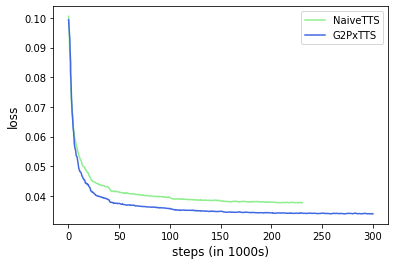

['NaiveTTS', 'G2PxTTS']


In [86]:
import numpy as np
import matplotlib.pyplot as plt
def my_tb_smooth(scalars, weight):  # Weight between 0 and 1
    """

    ref: https://stackoverflow.com/questions/42011419/is-it-possible-to-call-tensorboard-smooth-function-manually

    :param scalars:
    :param weight:
    :return:
    """
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed: list = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed


file = "afr_za_complete.csv"
loss_file = open(file, 'r')
loss_data = loss_file.readlines()
print(len(loss_data))
loss_arr = np.zeros(((len(loss_data)-1),2))
for i in range(1,len(loss_data)):
    loss_data[i] = loss_data[i].replace("\n","").split(",")
    loss_data[i] = loss_data[i]
    loss_arr[i-1,:] = (float(loss_data[i][1]), float(loss_data[i][2]))
file = "afr_za_incomplete_corrected.csv"
loss_file = open(file, 'r')
loss_data = loss_file.readlines()
print(len(loss_data))
loss_arr2 = np.zeros(((len(loss_data)-1),2))
for i in range(1,len(loss_data)):
    loss_data[i] = loss_data[i].replace("\n","").split(",")
    loss_data[i] = loss_data[i]
    loss_arr2[i-1,:] = (float(loss_data[i][1]), float(loss_data[i][2]))

print(loss_arr2.shape)

scale_2 = []
scale_1 = []

for i in range(len(loss_arr2)):
    # print(i)
    scale_2.append((loss_arr2[i][0],loss_arr2[i][1]))
    if i+1<len(loss_arr2) and i<len(loss_arr2):

        a = (loss_arr2[i][0],loss_arr2[i+1][0])
        b = (loss_arr2[i][1],loss_arr2[i+1][1])

        scale_2.append((np.mean(a),np.mean(b)))

for i in range(len(loss_arr)):
    scale_1.append((loss_arr[i][0],loss_arr[i][1]))
    if i+1<len(loss_arr) and i<len(loss_arr):

        a = (loss_arr[i][0],loss_arr[i+1][0])
        b = (loss_arr[i][1],loss_arr[i+1][1])

        scale_1.append((np.mean(a),np.mean(b)))

print(loss_arr[i:i+1][0])
print(np.mean(loss_arr[i:i+1][0]))

# print(scale_2[0])
# print(loss_arr2[0])
# print(scale_1[0])
# print(loss_arr[0])

combined = np.array((scale_2, scale_1))
print(combined.shape)

# combined = np.array((loss_arr2, loss_arr))
# print(combined.shape)

ax = plt.gca()
ans = ["NaiveTTS","G2PxTTS"]
colors_u = ["lightgreen", "royalblue"]
for i,j,k in zip(combined,ans,colors_u):
    color = next(ax._get_lines.prop_cycler)['color']
    # plt.plot(i[:,0]/1000, i[:,-1], label=j)
    plt.plot(i[:,0]/1000, my_tb_smooth(i[:,-1], 0.9), label=j, color=k)
    # plt. plot(j[1], 100*combined_models_losses[i,j[1],4],markersize=4, marker ='o', color=color)
    # ans.append((j[0],100*combined_models_losses[i,j[1],4]))
plt.locator_params(axis="x", integer=True, tight=True)
plt.legend(loc="upper right")
plt.savefig('../varyn_PER.pdf')
plt.xlabel('steps (in 1000s)',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.savefig('../tacotron_loss.pdf')
plt.show()
print(ans)
#afr_1919_6396885196

(2, 1000, 2)


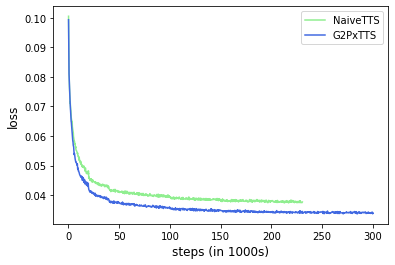

['NaiveTTS', 'G2PxTTS']


In [67]:
combined = np.array((loss_arr2, loss_arr))
print(combined.shape)

ax = plt.gca()
ans = ["NaiveTTS","G2PxTTS"]
colors_u = ["lightgreen", "royalblue"]
for i,j,k in zip(combined,ans,colors_u):
    color = next(ax._get_lines.prop_cycler)['color']
    #plt.plot(i[:,0]/1000, my_tb_smooth(i[:,-1], 0.66), label=j, color=k)
    plt.plot(i[:,0]/1000, i[:,-1], label=j, color=k)
    # plt. plot(j[1], 100*combined_models_losses[i,j[1],4],markersize=4, marker ='o', color=color)
    # ans.append((j[0],100*combined_models_losses[i,j[1],4]))
plt.locator_params(axis="x", integer=True, tight=True)
plt.legend(loc="upper right")
plt.savefig('../varyn_PER.pdf')
plt.xlabel('steps (in 1000s)',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.savefig('../tacotron_loss.pdf')
plt.show()
print(ans)
#afr_1919_6396885196